<h1>1. Data Collection</h1>

In [1]:
import requests
import pandas as pd

url = "https://archive-api.open-meteo.com/v1/archive"

base_params = {
    "latitude": 51.1694,
    "longitude": 71.4491,
    "start_date": "2008-01-01",
    "end_date": "2025-11-16",
    "timezone": "UTC",
    "models": "best_match"
}

hourly_params = base_params.copy()
hourly_params["hourly"] = "temperature_2m,relativehumidity_2m,dewpoint_2m"

res_hourly = requests.get(url, params=hourly_params).json()

if "hourly" not in res_hourly:
    raise ValueError("Hourly data missing:\n" + str(res_hourly))

df_h = pd.DataFrame(res_hourly["hourly"])
df_h["time"] = pd.to_datetime(df_h["time"])
df_h = df_h.set_index("time")

daily_params = base_params.copy()
daily_params["daily"] = "temperature_2m_max,temperature_2m_min,precipitation_sum"

res_daily = requests.get(url, params=daily_params).json()

if "daily" not in res_daily:
    raise ValueError("Daily data missing:\n" + str(res_daily))

df_d = pd.DataFrame(res_daily["daily"])
df_d["time"] = pd.to_datetime(df_d["time"])

df_d = df_d.set_index("time")


df_d_expanded = df_d.reindex(df_h.index, method="ffill")

df_final = pd.concat([df_h, df_d_expanded], axis=1)

df_final.to_csv("Kazakhstan_Weather_FULL_2008_2024.csv")

df_final


,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-01 00:00:00,-26.9,78,-29.6,-19.0,-27.2,0.0
2008-01-01 01:00:00,-27.0,78,-29.7,-19.0,-27.2,0.0
2008-01-01 02:00:00,-27.0,77,-29.8,-19.0,-27.2,0.0
2008-01-01 03:00:00,-27.2,78,-29.9,-19.0,-27.2,0.0
2008-01-01 04:00:00,-27.2,78,-29.9,-19.0,-27.2,0.0
...,...,...,...,...,...,...
2025-11-16 19:00:00,0.0,66,-5.5,3.8,-3.3,0.0
2025-11-16 20:00:00,-0.1,69,-5.1,3.8,-3.3,0.0
2025-11-16 21:00:00,-0.2,72,-4.6,3.8,-3.3,0.0


<h1>2. Data Preprocessing</h1>

In [7]:
df_final.describe()

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
count,156720.000000,156720.000000,156720.000000,156720.000000,156720.000000,156720.000000
mean,4.277761,66.937774,-2.411108,8.900475,-1.067764,1.026631
std,14.418261,20.343436,11.284345,14.846388,13.146600,2.472643
min,-42.700000,11.000000,-46.300000,-37.300000,-42.700000,0.000000
25%,-6.700000,51.000000,-9.700000,-3.200000,-10.700000,0.000000
50%,5.000000,72.000000,-1.200000,10.200000,0.250000,0.000000
75%,16.200000,84.000000,6.600000,22.100000,10.500000,0.800000
max,38.600000,100.000000,19.500000,38.600000,23.200000,37.400000


<h3>MISSING VALUES AND DUPLICATES</h3>

In [4]:
import pandas as pd

df = pd.read_csv("Kazakhstan_Weather_FULL_2008_2024.csv", parse_dates=["time"], index_col="time")

print("Shape:", df.shape)
print(df.isna().sum().sort_values(ascending=False))


Shape: (156720, 6)
temperature_2m         0
relativehumidity_2m    0
dewpoint_2m            0
temperature_2m_max     0
temperature_2m_min     0
precipitation_sum      0
dtype: int64


In [8]:
duplicates = df_final.index.duplicated().sum()
print("Number of duplicate timestamps:", duplicates)


Number of duplicate timestamps: 0


<h3>RESAMPLING</h3>

In [5]:
df_resampled_h = df  #hourly
df_resampled_h

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-01 00:00:00,-26.9,78,-29.6,-19.0,-27.2,0.0
2008-01-01 01:00:00,-27.0,78,-29.7,-19.0,-27.2,0.0
2008-01-01 02:00:00,-27.0,77,-29.8,-19.0,-27.2,0.0
2008-01-01 03:00:00,-27.2,78,-29.9,-19.0,-27.2,0.0
2008-01-01 04:00:00,-27.2,78,-29.9,-19.0,-27.2,0.0
...,...,...,...,...,...,...
2025-11-16 19:00:00,0.0,66,-5.5,3.8,-3.3,0.0
2025-11-16 20:00:00,-0.1,69,-5.1,3.8,-3.3,0.0
2025-11-16 21:00:00,-0.2,72,-4.6,3.8,-3.3,0.0


In [6]:
df_resampled_d = df.resample("D").mean()  #daily
df_resampled_d

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-01,-23.816667,77.875000,-26.604167,-19.0,-27.2,0.0
2008-01-02,-20.400000,81.083333,-22.795833,-14.8,-24.9,0.2
2008-01-03,-24.108333,76.333333,-27.104167,-16.8,-31.6,0.2
2008-01-04,-28.600000,73.583333,-31.833333,-25.5,-32.3,0.0
2008-01-05,-24.883333,74.000000,-28.179167,-21.2,-27.0,0.0
...,...,...,...,...,...,...
2025-11-12,0.258333,95.166667,-0.420833,2.4,-4.1,2.7
2025-11-13,-4.520833,80.958333,-7.329167,-2.6,-8.0,0.1
2025-11-14,-2.954167,78.125000,-6.266667,-0.3,-7.5,0.0


In [7]:
df_resampled_w = df.resample("W").mean()  #weekly
df_resampled_w

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-06,-23.729861,76.631944,-26.684028,-18.950000,-28.300000,0.066667
2008-01-13,-17.477976,81.726190,-19.855357,-14.028571,-21.100000,0.200000
2008-01-20,-23.207738,76.940476,-26.132143,-19.328571,-27.471429,0.000000
2008-01-27,-21.127381,77.553571,-24.033929,-15.314286,-26.185714,0.000000
2008-02-03,-15.367262,83.702381,-17.505357,-10.200000,-20.328571,0.000000
...,...,...,...,...,...,...
2025-10-19,0.143452,61.464286,-6.751786,5.328571,-4.514286,0.000000
2025-10-26,3.804762,66.642857,-2.164286,9.742857,-1.671429,0.114286
2025-11-02,3.880357,74.095238,-0.562500,8.614286,-0.528571,1.685714


In [8]:
df_resampled_m = df.resample("ME").mean()  #monthly end
df_resampled_m

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-31,-20.900672,78.505376,-23.662769,-16.177419,-25.487097,0.058065
2008-02-29,-11.056034,83.563218,-13.306178,-8.410345,-14.682759,0.368966
2008-03-31,-0.473253,77.783602,-4.380242,4.190323,-5.912903,1.635484
2008-04-30,5.654167,54.081944,-4.028056,12.320000,-2.243333,0.736667
2008-05-31,15.545296,49.981183,3.802419,21.645161,7.367742,0.870968
...,...,...,...,...,...,...
2025-07-31,20.619086,62.220430,12.412903,25.532258,14.883871,1.570968
2025-08-31,17.787500,64.330645,10.279032,22.593548,12.393548,1.983871
2025-09-30,12.732778,69.538889,6.890417,17.290000,7.903333,0.903333


<h3>Stationarity and differencing</h3>

In [9]:
from statsmodels.tsa.stattools import adfuller

target = df_resampled_h["temperature_2m"].dropna()

result = adfuller(target)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -9.209023085718114
p-value: 1.909975650389229e-15


p-value < 0.05 → Stationary

p-value ≥ 0.05 → Not stationary → must difference

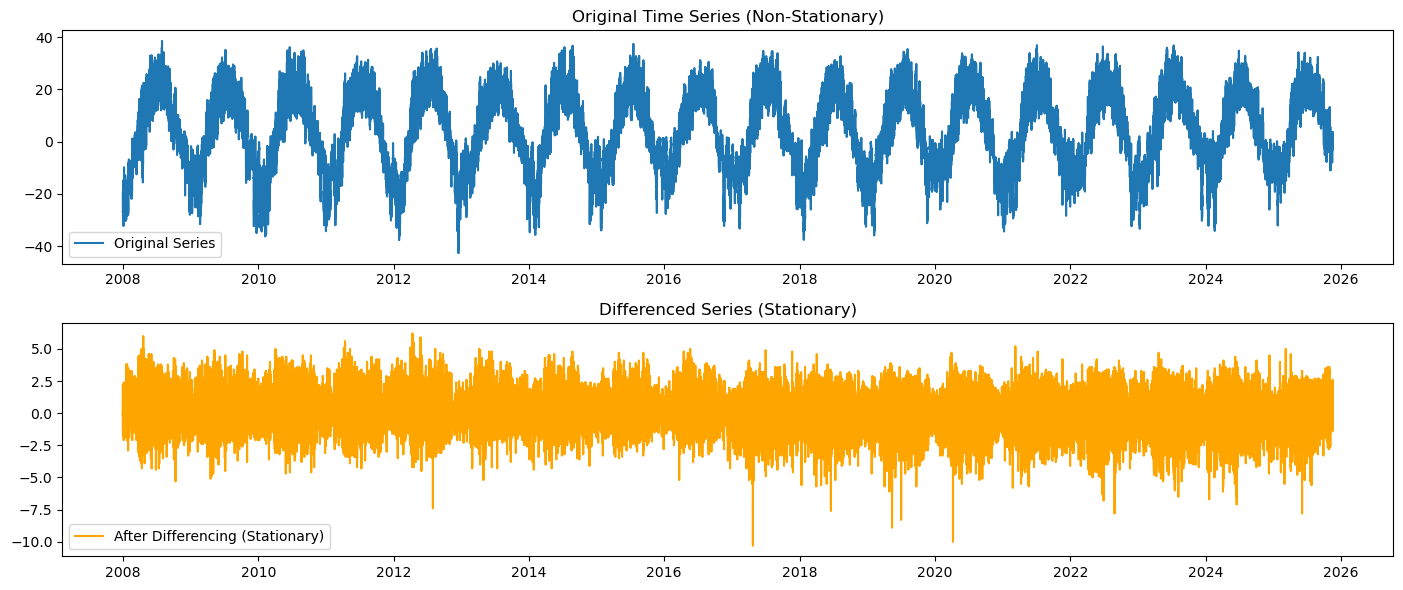

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

ts = df_resampled_h["temperature_2m"]

ts_diff = ts.diff().dropna()

plt.figure(figsize=(14,6))

plt.subplot(2,1,1)
plt.plot(ts, label="Original Series")
plt.title("Original Time Series (Non-Stationary)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(ts_diff, label="After Differencing (Stationary)", color="orange")
plt.title("Differenced Series (Stationary)")
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
result = adfuller(ts_diff)
print("After differencing — p-value:", result[1])


After differencing — p-value: 0.0


<h3>Normalize / Scale the data</h3>

normalizing daily data using MinMaxScaler

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_resampled_d),
    index=df_resampled_d.index,
    columns=df_resampled_d.columns
)
df_scaled

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-01,0.227517,0.733079,0.277621,0.241107,0.235205,0.000000
2008-01-02,0.275403,0.775109,0.339046,0.296443,0.270106,0.005348
2008-01-03,0.223429,0.712882,0.269556,0.270092,0.168437,0.005348
2008-01-04,0.160477,0.676856,0.193280,0.155468,0.157815,0.000000
2008-01-05,0.212567,0.682314,0.252218,0.212121,0.238240,0.000000
...,...,...,...,...,...,...
2025-11-12,0.564938,0.959607,0.699933,0.523057,0.585736,0.072193
2025-11-13,0.497956,0.773472,0.588508,0.457181,0.526555,0.002674
2025-11-14,0.519914,0.736354,0.605645,0.487484,0.534143,0.000000


normalizing weekly data using StandardScaler

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_resampled_w),
    index=df_resampled_w.index,
    columns=df_resampled_w.columns
)
df_scaled

,temperature_2m,relativehumidity_2m,dewpoint_2m,temperature_2m_max,temperature_2m_min,precipitation_sum
time,,,,,,
2008-01-06,-2.063388,0.668561,-2.313513,-1.940076,-2.146399,-0.786531
2008-01-13,-1.602726,1.019921,-1.662552,-1.597195,-1.578822,-0.677270
2008-01-20,-2.024916,0.689841,-2.260903,-1.966452,-2.081083,-0.841162
2008-01-27,-1.871628,0.732127,-2.060886,-1.686772,-1.979730,-0.841162
2008-02-03,-1.447201,1.156223,-1.438532,-1.330454,-1.518010,-0.841162
...,...,...,...,...,...,...
2025-10-19,-0.304313,-0.377584,-0.413420,-0.248562,-0.271366,-0.841162
2025-10-26,-0.034534,-0.020407,0.023896,0.058986,-0.047263,-0.747509
2025-11-02,-0.028964,0.493599,0.176591,-0.019643,0.042829,0.540212


<h1>3. Exploratory Data Analysis (EDA)</h1>

<h3>Decompose</h3>

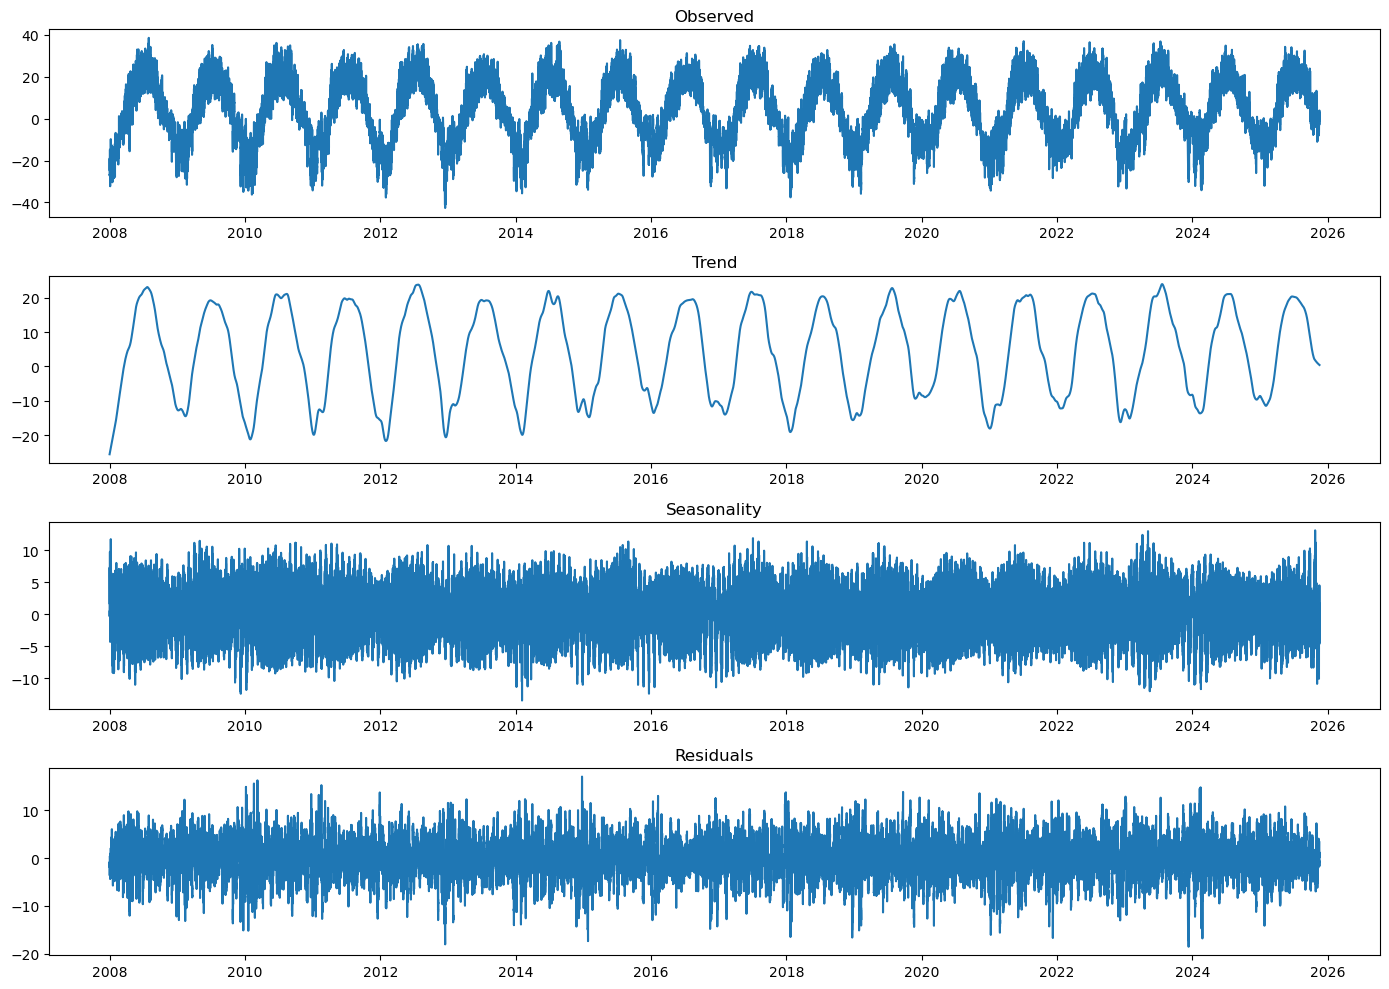

In [12]:
from statsmodels.tsa.seasonal import STL

stl = STL(ts, period=24*30)   
result = stl.fit()

plt.figure(figsize=(14,10))

plt.subplot(4,1,1)
plt.plot(result.observed)
plt.title("Observed")

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.title("Trend")

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.title("Seasonality")

plt.subplot(4,1,4)
plt.plot(result.resid)
plt.title("Residuals")

plt.tight_layout()
plt.show()


<h3>moving averages</h3>

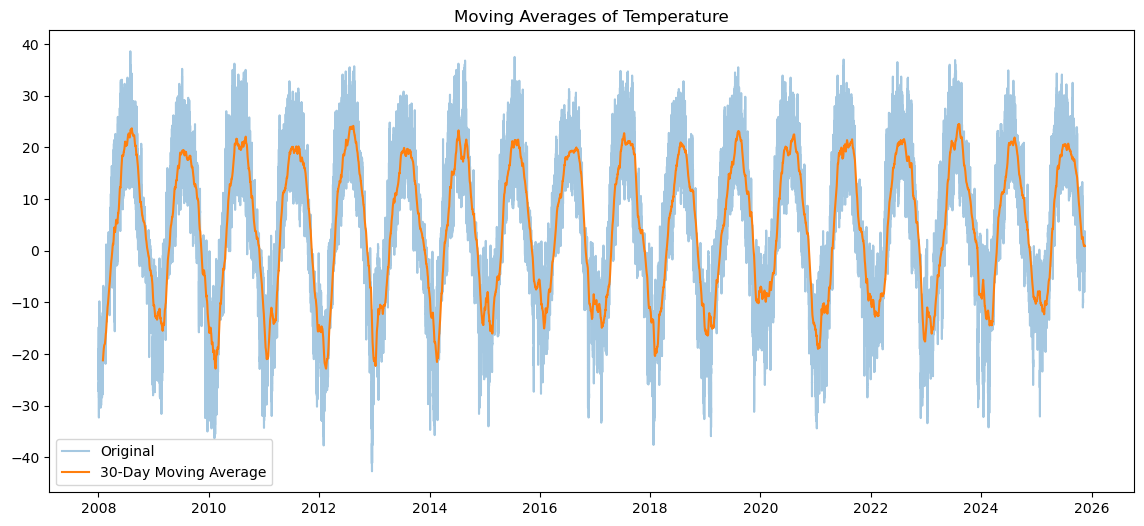

In [21]:
ma_30d = ts.rolling(24*30).mean()

plt.figure(figsize=(14,6))

plt.plot(ts, label="Original", alpha=0.4)
plt.plot(ma_30d, label="30-Day Moving Average")

plt.title("Moving Averages of Temperature")
plt.legend()
plt.show()


<h3>(ACF) and (PACF)</h3>

<Figure size 1400x500 with 0 Axes>

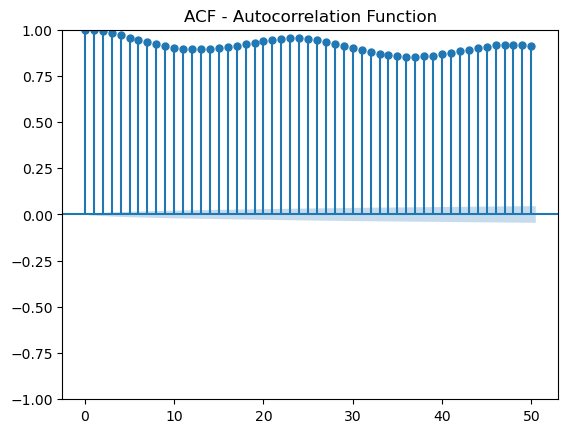

<Figure size 1400x500 with 0 Axes>

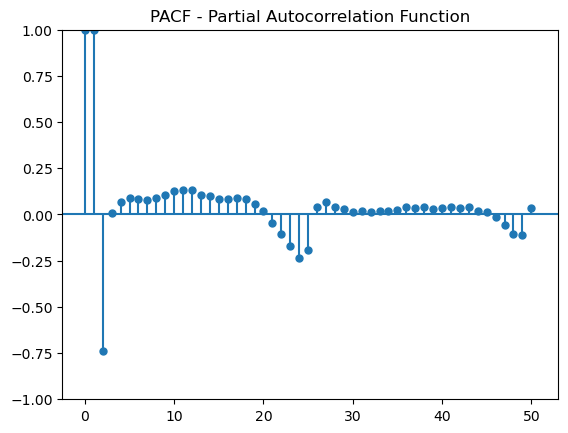

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,5))
plot_acf(ts.dropna(), lags=50)
plt.title("ACF - Autocorrelation Function")
plt.show()

plt.figure(figsize=(14,5))
plot_pacf(ts.dropna(), lags=50, method="ywm")
plt.title("PACF - Partial Autocorrelation Function")
plt.show()


<h3>outliers</h3>

Outliers BEFORE cleaning: 36
Outliers AFTER cleaning: 0


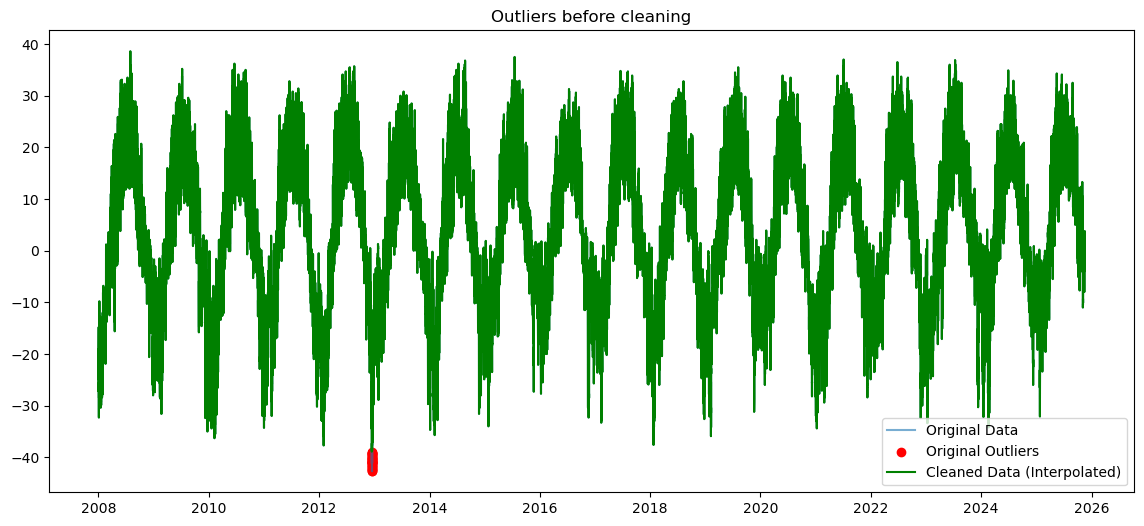

In [7]:
import numpy as np
import matplotlib.pyplot as plt

z_scores = (ts - ts.mean()) / ts.std()
outliers_before = ts[np.abs(z_scores) > 3]
print("Outliers BEFORE cleaning:", len(outliers_before))

ts_clean = ts.copy()

ts_clean[np.abs(z_scores) > 3] = np.nan

ts_clean = ts_clean.interpolate(method="linear")

z_scores_after = (ts_clean - ts_clean.mean()) / ts_clean.std()
outliers_after = ts_clean[np.abs(z_scores_after) > 3]

print("Outliers AFTER cleaning:", len(outliers_after))

plt.figure(figsize=(14,6))
plt.plot(ts, label="Original Data", alpha=0.6)
plt.scatter(outliers_before.index, outliers_before, color="red", label="Original Outliers")

plt.plot(ts_clean, label="Cleaned Data (Interpolated)", color="green")
plt.title("Outliers before cleaning")
plt.legend()
plt.show()


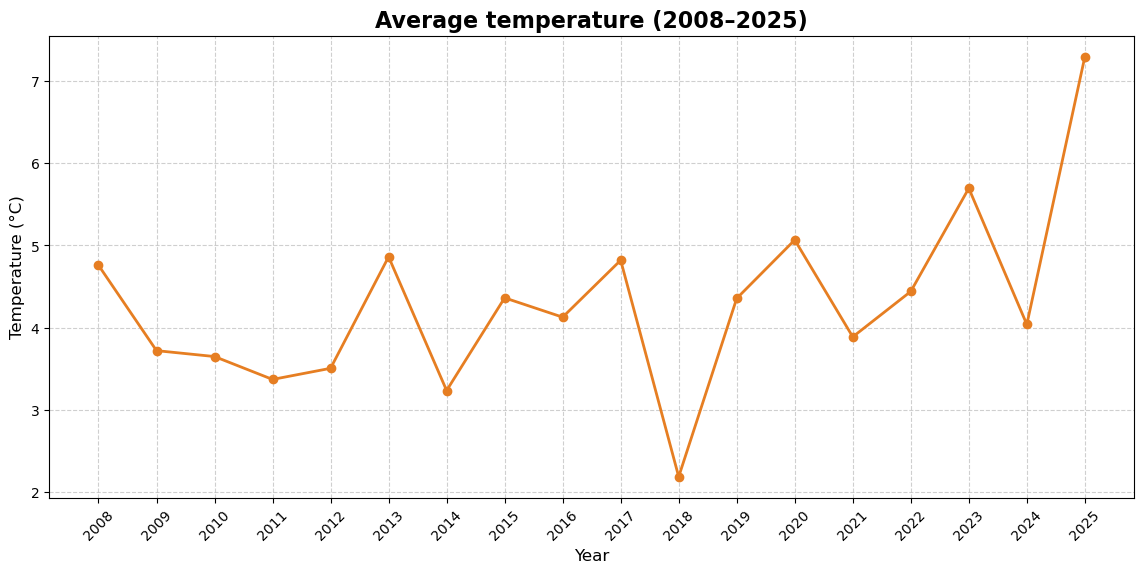

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df_final.index = pd.to_datetime(df_final.index)
ts_daily = df_final["temperature_2m"].resample("D").mean()
yearly_temp = ts_daily.resample("Y").mean()
yearly_temp.index = yearly_temp.index.year
plt.figure(figsize=(14, 6))
plt.plot(yearly_temp.index, yearly_temp.values, marker="o", linewidth=2, color="#e67e22")

plt.title("Average temperature (2008–2025)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(yearly_temp.index, rotation=45)

plt.show()


<h1>4. Model Implementation</h1>

In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

ts_daily = ts_clean.resample("D").mean().dropna()

ts_daily.index = pd.to_datetime(ts_daily.index)

train = ts_daily.iloc[:-365]
test = ts_daily.iloc[-365:]

model_arima = ARIMA(train, order=(1,1,0))
arima_fit = model_arima.fit()

arima_forecast = arima_fit.forecast(steps=365)


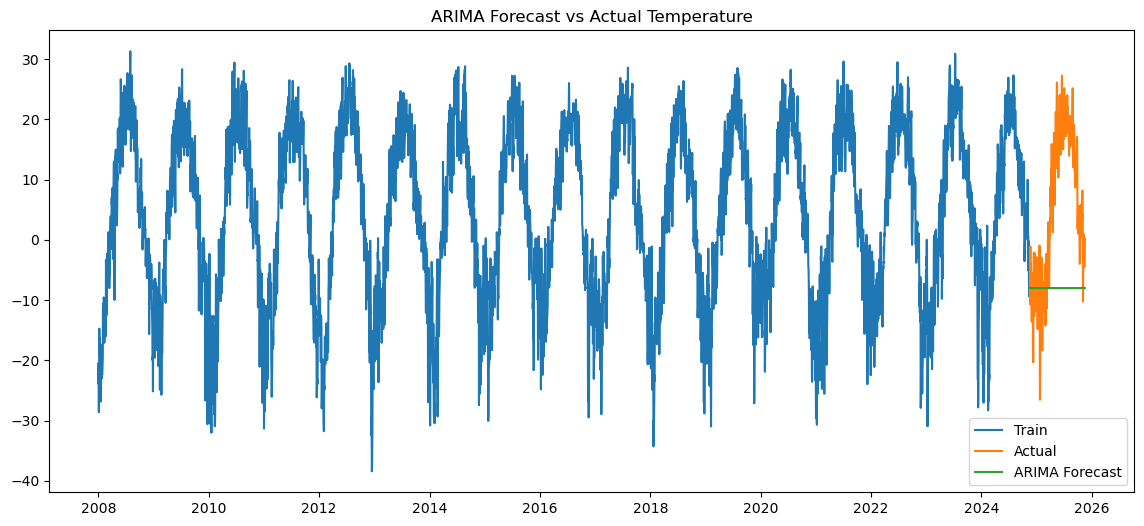

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecast vs Actual Temperature")
plt.legend()
plt.show()

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=365
)

hw_fit = model_hw.fit()
hw_forecast = hw_fit.forecast(365)

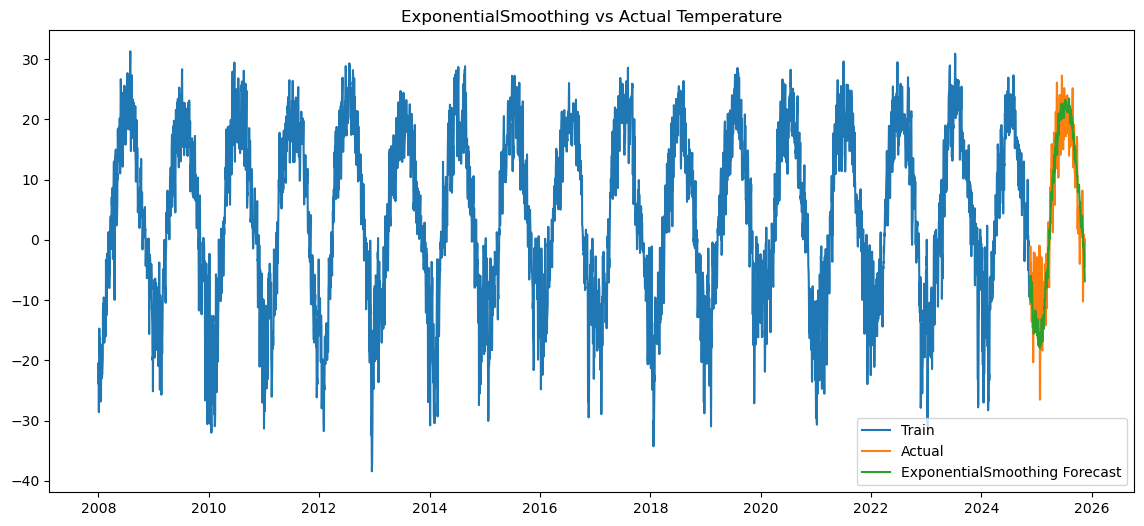

In [48]:
plt.figure(figsize=(14,6))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(hw_forecast, label="ExponentialSmoothing Forecast")
plt.title("ExponentialSmoothing vs Actual Temperature")
plt.legend()
plt.show()

In [21]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [71]:
import pandas as pd

ts_daily = ts_clean.resample("D").mean().dropna()

df_prophet = ts_daily.reset_index()
df_prophet.columns = ["ds", "y"]   

In [86]:
train = df_prophet.iloc[:-365]
test = df_prophet.iloc[-365:]

In [79]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,    
    daily_seasonality=False,
    seasonality_mode="additive"
)

model.fit(train)

23:00:27 - cmdstanpy - INFO - Chain [1] start processing
23:00:28 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
ph_future = model.make_future_dataframe(periods=365)
ph_forecast = model.predict(future)

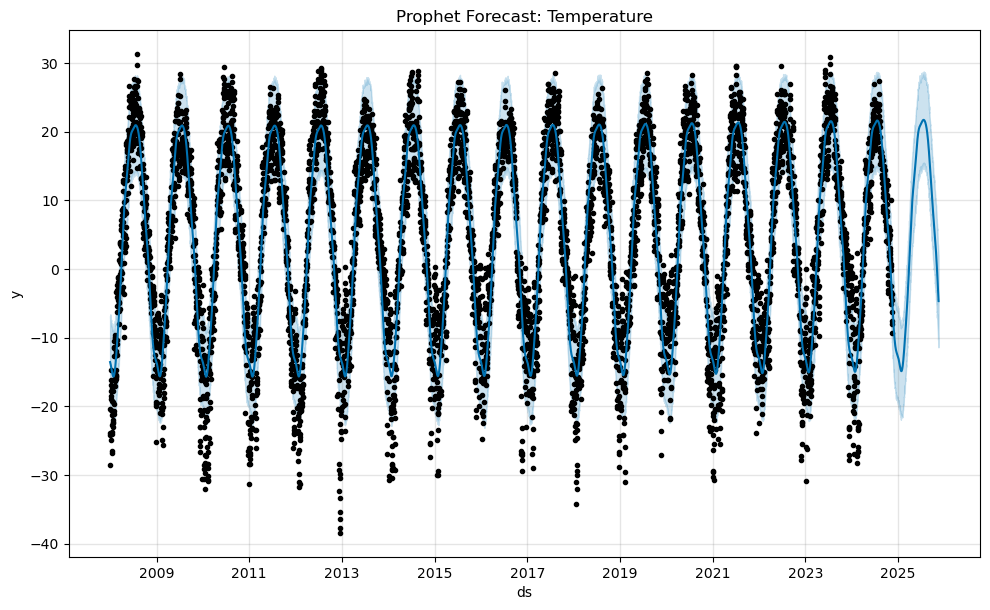

In [81]:
import matplotlib.pyplot as plt

fig1 = model.plot(ph_forecast)
plt.title("Prophet Forecast: Temperature")
plt.show()

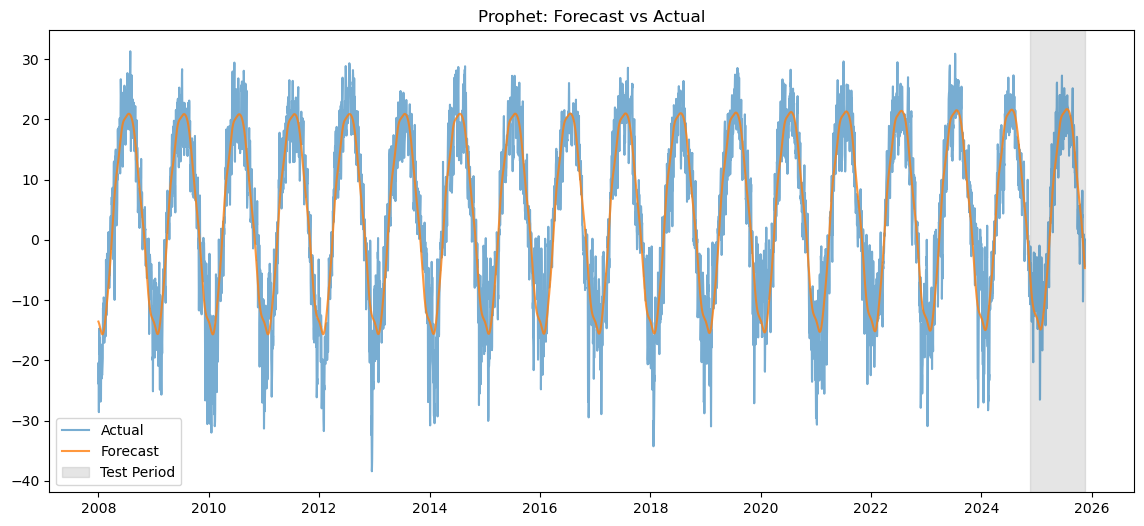

In [82]:
plt.figure(figsize=(14,6))

plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual", alpha=0.6)
plt.plot(ph_forecast["ds"], ph_forecast["yhat"], label="Forecast", alpha=0.8)

plt.axvspan(test["ds"].iloc[0], test["ds"].iloc[-1], color="gray", alpha=0.2, label="Test Period")

plt.legend()
plt.title("Prophet: Forecast vs Actual")
plt.show()


<h1>5. Model Evaluation</h1>

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [59]:
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)
arima_mape = mape(test, arima_forecast)

print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)
print("ARIMA MAPE:", arima_mape)

ARIMA RMSE: 16.52727313425424
ARIMA MAE: 13.54724993360761
ARIMA MAPE: 233.80776902065296


In [60]:
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_mae = mean_absolute_error(test, hw_forecast)
hw_mape = mape(test, hw_forecast)

print("Holt-Winters RMSE:", hw_rmse)
print("Holt-Winters MAE:", hw_mae)
print("Holt-Winters MAPE:", hw_mape)

Holt-Winters RMSE: 4.777141287837046
Holt-Winters MAE: 3.7910697267335345
Holt-Winters MAPE: 157.37946014126612


In [93]:
from prophet import Prophet

df_prophet = ts_daily.reset_index()
df_prophet.columns = ["ds", "y"]

train_p = df_prophet.iloc[:-365]
test_p  = df_prophet.iloc[-365:]
test_p = test_p.set_index("ds")

model = Prophet(yearly_seasonality=True, seasonality_mode="multiplicative")
model.fit(train_p)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast_p = forecast.set_index("ds").loc[test_p.index]

prophet_mae = mean_absolute_error(test_p["y"], forecast_p["yhat"])
prophet_rmse = mean_squared_error(test_p["y"], forecast_p["yhat"])
prophet_mape = mape(test_p["y"], forecast_p["yhat"])


print("Prophet MAE:", prophet_mae)
print("Prophet RMSE:", prophet_rmse)
print("Prophet MAPE:", prophet_mape)

23:19:46 - cmdstanpy - INFO - Chain [1] start processing
23:19:49 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 3.645450729091915
Prophet RMSE: 20.9065011366349
Prophet MAPE: 126.42805290293764


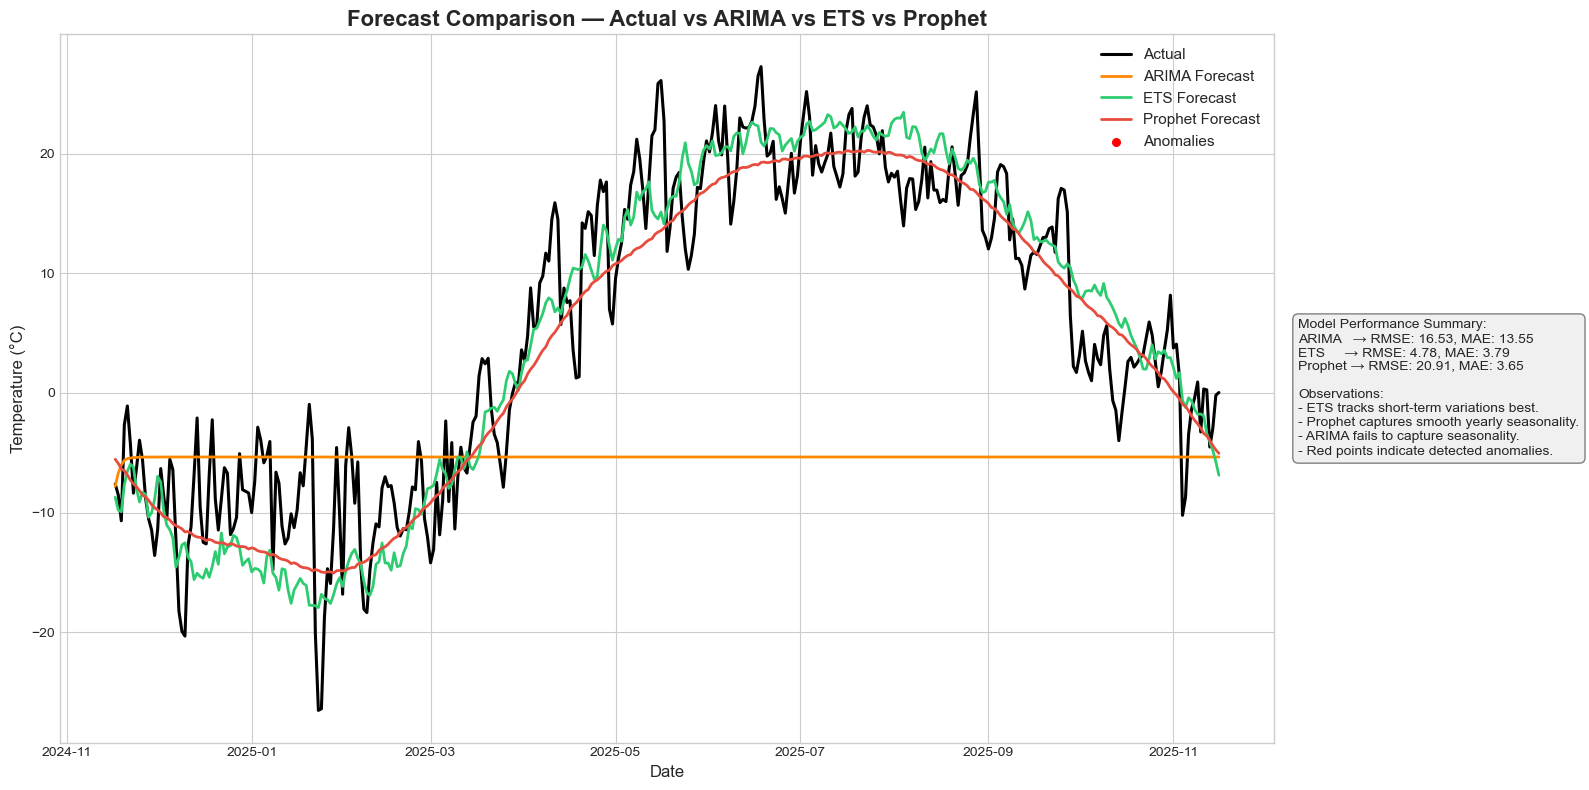

In [105]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

z_scores = (test - test.mean()) / test.std()
anomalies = test[np.abs(z_scores) > 3]

plt.figure(figsize=(16, 8))

plt.plot(test.index, test, label="Actual", linewidth=2.2, color="black")

plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="#ff8800", linewidth=2)

plt.plot(test.index, hw_forecast, label="ETS Forecast", color="#2ecc71", linewidth=2)

plt.plot(test.index, forecast_p["yhat"], label="Prophet Forecast", color="#e74c3c", linewidth=2)

plt.scatter(anomalies.index, anomalies, color="red", s=30, label="Anomalies", zorder=5)

plt.title("Forecast Comparison — Actual vs ARIMA vs ETS vs Prophet",
          fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

plt.legend(fontsize=11)

textstr = (
    "Model Performance Summary:\n"
    f"ARIMA   → RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}\n"
    f"ETS     → RMSE: {hw_rmse:.2f}, MAE: {hw_mae:.2f}\n"
    f"Prophet → RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}\n\n"
    "Observations:\n"
    "- ETS tracks short-term variations best.\n"
    "- Prophet captures smooth yearly seasonality.\n"
    "- ARIMA fails to capture seasonality.\n"
    "- Red points indicate detected anomalies."
)

plt.gca().text(
    1.02, 0.5, textstr, transform=plt.gca().transAxes,
    fontsize=10, verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="#f0f0f0", edgecolor="gray")
)

plt.tight_layout()
plt.show()


Three forecasting models—ARIMA, Exponential Smoothing (ETS), and Prophet—were tested and compared using MAE, RMSE, and MAPE. ARIMA performed the worst: it produced nearly flat predictions and failed to capture the clear seasonal structure in the temperature series. The ETS model achieved the lowest RMSE and tracked the real temperature variations most accurately, demonstrating strong performance on short-term daily forecasting. Prophet achieved the lowest MAE and modeled the long-term annual cycle well, but its forecasts were overly smooth and did not capture short-term fluctuations, resulting in a higher RMSE than ETS.

Overall, ETS provided the most accurate day-to-day forecasts, while Prophet provided the most stable long-term seasonal trend. ARIMA was not suitable for this dataset due to its inability to model strong seasonality.